## Assignment 2
In this exercise you will:
 * Compute an implicit MLS function approximating a 3D point cloud with given (but possibly unnormalized) normals.
 * Sample the implicit function on a 3D volumetric grid.
 * Apply the marching tets algorithm to extract a triangle mesh of this zero level set.
 * Experiment with various MLS reconstruction parameters.

Your main task is to construct an implicit function `f(x)` defined on all `x`  R<sup>3</sup> whose zero level set contains (or at least passes near) each input point. That is, for every point `pi` in the point cloud, we want `f(pi) = 0`. Furthermore, `∂f` (the isosurface normal) evaluated at each point cloud location should approximate the point's normal provided as input.

In [199]:
import numpy as np
import igl
import meshplot as mp
import math
import matplotlib.pyplot as plt

In [200]:
# Utility function to generate a tet grid
# n is a 3-tuple with the number of cell in every direction
# mmin/mmax are the grid bounding box corners
# returns V - vertices of the grid

def tet_grid(n, mmin, mmax):
    nx = n[0]
    ny = n[1]
    nz = n[2]
    
    delta = mmax-mmin
    
    deltax = delta[0]/(nx-1)
    deltay = delta[1]/(ny-1)
    deltaz = delta[2]/(nz-1)
    
    T = np.zeros(((nx-1)*(ny-1)*(nz-1)*6, 4), dtype=np.int64)
    V = np.zeros((nx*ny*nz, 3))

    mapping = -np.ones((nx, ny, nz), dtype=np.int64)


    index = 0
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                mapping[i, j, k] = index
                V[index, :] = [i*deltax, j*deltay, k*deltaz]
                index += 1
    assert(index == V.shape[0])
    
    tets = np.array([
        [0,1,3,4],
        [5,2,6,7],
        [4,1,5,3],
        [4,3,7,5],
        [3,1,5,2],
        [2,3,7,5]
    ])
    
    index = 0
    for i in range(nx-1):
        for j in range(ny-1):
            for k in range(nz-1):
                indices = [
                    (i,   j,   k),
                    (i+1, j,   k),
                    (i+1, j+1, k),
                    (i,   j+1, k),

                    (i,   j,   k+1),
                    (i+1, j,   k+1),
                    (i+1, j+1, k+1),
                    (i,   j+1, k+1),
                ]
                
                for t in range(tets.shape[0]):
                    tmp = [mapping[indices[ii]] for ii in tets[t, :]]
                    T[index, :]=tmp
                    index += 1
                    
    assert(index == T.shape[0])
    
    V += mmin
    return V, T

# Reading point cloud | output: cloud with constraints

In [201]:
def find_closest_point(query_point, point_set):
    dist = np.linalg.norm(point_set - query_point, axis=1)
    return np.argmin(dist)

In [202]:
"""
pp = p+ 
npp = p- 
"""
def setupConstraints(pis, ni, eps, ps):
    f = np.zeros(len(pis) * 3)
    pps = np.zeros_like(pis)  # positive points
    nps = np.zeros_like(pis)  # negative points
    # compute p+
    for idx, pi in enumerate(pis):
        pp = pi + eps * ni[idx]
        cp = find_closest_point(pp, pis)
        new_eps = eps
        while cp != idx:
            new_eps /= 2  # Reduce step size
            pp = pi + new_eps * ni[idx]
            # print("not closest point!")
            cp = find_closest_point(pp, pis)
        pps[idx]=pp
        f[len(pis) + idx] = new_eps
    # compute p-
    for idx, pi in enumerate(pis):
        npp = pi - eps * ni[idx]  # Negative offset
        cp = find_closest_point(npp, pis)
        new_eps = eps
        while cp != idx:
            new_eps /= 2
            npp = pi - new_eps * ni[idx]
            print("not closest point!")
            cp = find_closest_point(npp, pis)
        nps[idx]=npp
        f[2*len(pis) + idx] = -new_eps
    p=np.concatenate((pis, pps, nps), axis=0)
    print("length of p = 3n: ", len(p) == (len(pis)+len(pps)+len(nps))) #check to make sure p is correct
    print("length of f = 3n: ", len(f) == (len(pis)*3)) #check to make sure f is correct
    # plot 3 set of points
    plot = mp.plot(pis, shading={"point_color": "blue", "point_size": ps})   # blue = on surface
    plot.add_points(pps, shading={"point_color": "red", "point_size": ps})   # red = outside 
    plot.add_points(nps, shading={"point_color": "green", "point_size": ps}) # green = inside 
    return p,f

In [203]:
""" Required output of this section: Plot of the provided point cloud shaded with green, blue, and red dots."""
pi_cat, v_cat = igl.read_triangle_mesh("data/cat.off")
pi_cat /= 10
ni_cat = igl.per_vertex_normals(pi_cat, v_cat)
eps = 1
ps = 4
p_cat, f_cat = setupConstraints(pi_cat, ni_cat, eps, ps)

length of p = 3n:  True
length of f = 3n:  True


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.0, -23.…

### Create a grid sampling the 3D space:  
Create a regular volumetric grid around your point cloud: compute the axis-aligned bounding box of the point cloud, enlarge it slightly, and divide it into uniform cells (tets). The grid resolution is configured by
the global variable `resolution`, which can be changed. *Note* the funciton to generate the grid is provided. We call the grid vertices `x` and the tets connecting them `T`.

In [204]:
minimum = -float('inf') # temporary value to help us compute the bounding box 
maximum = float('inf')
resolution = 0.05 # we multiply the box diagonal by this when making the tetrahedral gird

#function to get margins for bounding box
def boundingBox(pis):
    min_values = np.min(pis, axis=0)
    max_values = np.max(pis, axis=0)
    return min_values, max_values

def create3dGrid(pis, n, ps_grid, ps_mesh,showCheck=False, resolution=0.05):
    bbox_min, bbox_max = boundingBox(pis) # compute bounding box of the point cloud 
    print(bbox_min, bbox_max)
    box_diag = np.linalg.norm(bbox_max - bbox_min)
    x,T = tet_grid((n,n,n), bbox_min-resolution*box_diag, bbox_max + resolution * box_diag)
    if(showCheck):# show if object fits inside grid
        plot = mp.plot(x, shading={"point_color": "black",  "point_size": ps_grid})
        plot.add_points(pis, shading={"point_color": "blue", "point_size": ps_mesh})
    return x,T

### MLS Interpolation | Output : cloud with plot of the grid points x colored according of being inside or outside the input cloud.
We now use MLS interpolation to construct an implicit function satisfying the constraints as nearly as possible.
We won't define the function with an explicit formula; instead we characterize it as the linear combination of polynomial basis functions that best satisfies the constraints in some sense. At a given point `xi` in `x`, you evaluate this function by finding the "optimal" basis function coefficients (which will vary from point to point!) and using these to combine the basis function values at `xi`.

Complete the appropriate source code sections to evaluate the MLS function at every node `xi` of a regular volumetric
grid containing the input point cloud. As an example, the provided code computes the grid values for an implicit function representing a sphere (MLS wasn't used in
this case since the formula is known analytically).


More specifically, for each grid node `xi` of the grid, evaluate the implicit function `f(xi)`, whose zero level set approximates the point cloud.
Use the moving least squares approximation presented in class and in the tutoring session. You should use the
Wendland weight function with radius configured by `wendlandRadius` and degree `k = 0, 1, 2` polynomial basis functions configured by `polyDegree`. Only use the constraint points with nonzero weight (i.e., points `p` with `||xi - p|| < wendlandRadius`). *Note* if the number of constraint points within `wendlandRadius` is less than twice the number of polynomial coefficients (i.e., 1 for `k = 0`, 4 for `k = 1`, and 10 for `k = 2`), you can assign a large positive (outside) value to the grid point.

Store the field value  `fx = f(xi)` in a  `numpy.array`, using the same ordering as in `x`. Render these values by coloring each grid point red/green depending if they are inside outside (i.e., `fx < 0` or `fx ≥ 0`). You can use the `meshplot.plot(..., c=color)` where `color` is a `n x 3` matrix containing rgb values.

**Important**: explicitty write a function `closest_points(point, points, h)` that retreives the indices all points in `points` that are at distance less than `h` from `point`.

*Relevant `numpy` functions:* `argwhere`, `linalg.solve`.

Required output of this section:

 * Plot of the grid points `x` colored according of being inside or outside the input cloud.


In [205]:
"""
Goal: find the best f in the span of chosen basis functions 
    f(x) = sum_j b_j(x)a_j, where the basis is a polynomial function 
"""

""" 
Compute polynomial basis (at a point) in 2nd degree

1,x,y,z,x^2,y^2,z^2,xy,xz,yz
""" 
def polynomialBasis(point, degree =2):
    x,y,z = point
    # if degree==1:
    #     return np.array([1,x,y,z])
    # return np.array([1,x,y,z,x**2,y**2,z**2,x*y,x*z,y*z]) 
    return np.array([1,x,y,z])

def polynomialBasisMat(x):
    B = np.apply_along_axis(polynomialBasis, axis=1, arr=x)
    return B
def mls_interpolate(p,f, x,T, wendlandRadius):
    # We want to solve (B^TW(x)B)a(x)=B^TW(x)d, where W = wendland weight matrix 
    # check to make sure p and x have same dimensionality 
    assert p.shape[1] == x.shape[1]
    # 1. Compute B (the polynomial basis of p) -- polynomial 3d basis = 1,x,y,z,x^2,y^2,z^2,xy,xz,yz
    B = polynomialBasisMat(p)
    print("Shape of B: ", B.shape)

    # 2. Compute W  -- for each evaluation point, evaluate pi, in p, W_ii = w||x-p_i||
    ##  x[:, None, :] has shape (k, 1, d)
    ##  p[None, :, :] has shape (1, 3n, d)
    ##  resulting distances have shape (k, 3n)
    distances = np.linalg.norm(x[:, None, :] - p[None, :, :], axis=2) # using numpy broadcasting
    # print("Distances shape:", distances.shape)
    weights = wendland(distances, wendlandRadius) # getting the wendland weights for all distances at once
    print(weights)
    # For each point x compute a, and then fx
    fx = np.zeros(len(x))
    for i in range(len(x)):
        W_i = np.diag(weights[i]) # computing wendland matrix 
        # print("Wi shape:", W_i.shape)
        BTW = B.T @ W_i
        lhs = BTW @ f
        rhs = BTW @ B
        coeff = np.linalg.solve(rhs, lhs)
        # now we have to compute f(x) at every point for every a 
        basis_at_x_i = polynomialBasis(x[i])
        fx[i] = np.dot(basis_at_x_i, coeff)
    return fx    

def mls_interpolate_with_close_points(p,f, x,T, closestPointDist, wendlandRadius):
    # We want to solve (B^TW(x)B)a(x)=B^TW(x)d, where W = wendland weight matrix 
    assert p.shape[1] == x.shape[1]
    fx = np.zeros(len(x))
    for i in range(len(x)):
        # get the indices closest points to x
        indices = closest_points(x[i], p, closestPointDist)
        if len(indices) < 4:
            continue  
        # get the actual closest points to x
        p_closest = p[indices]  
        f_closest = f[indices]
        # compute B
        B = polynomialBasisMat(p_closest)
        # get the weights and wendland matrix 
        distances = np.linalg.norm(x[i] - p_closest, axis=1)  
        weights = wendland(distances, wendlandRadius)
        W_i = np.diag(weights) # computing wendland matrix 
        # solve for coefficients (a) 
        BTW = B.T @ W_i
        lhs = BTW @ f_closest
        rhs = BTW @ B
        coeff = np.linalg.solve(rhs, lhs)
        # compute f(x) = b(x)a(x)
        basis_at_x_i = polynomialBasis(x[i])
        fx[i] = np.dot(basis_at_x_i, coeff)
    return fx
"""
returns the indices of the points within distance h of point, point
"""
def closest_points(query_point, point_set, h):
    dist = np.linalg.norm(point_set - query_point, axis=1)
    return np.where(dist < h)[0]

"""
Computes wendland weight 
r is the Euclidean distance from the evaluation point.
h (the Wendland radius) defines the range of influence.
"""
def wendland(r, h):
    return np.maximum(0,(1-r/h)**4*(4*r/h+1)) 

In [206]:
## Reading in the mesh
pi, v = igl.read_triangle_mesh("data/cat.off")
pi /= 10
ni = igl.per_vertex_normals(pi, v)
# mp.plot(pi, shading={"point_size": 8})
## Setting constraints
eps = 1
ps = 4
p,f=setupConstraints(pi, ni, eps, ps)
## Adding the Grid def create3dGrid(pis, n, ps_grid, ps_mesh,showCheck=False, resolution=0.05):
x, T = create3dGrid(p, 20, 2,4,True) # was 80 | 1 |  5
## Running the interpolation 
# fx = mls_interpolate_with_close_points(p,f, x,T, 50, 7)
fx = mls_interpolate_with_close_points(p,f, x,T, 25, 20)

length of p = 3n:  True
length of f = 3n:  True


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.0, -23.…

[-23.68137397 -64.69682439 -99.63522961] [33.69826224 17.66157433  6.79268375]


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.0084438…

In [207]:
"""Required output : points inside and outside the mesh
Also shown : mls interpolation for the cat"""
## Checking points inside and outside the grid
ind = np.zeros_like(fx)
ind[fx >= 0] = 1
ind[fx < 0] = -1
mp.plot(x, c=ind, shading={"point_size": 7,"width": 800, "height": 800})
## Running marching tets
sv, sf, _, _ = igl.marching_tets(x, T, fx, 0) ## SV AND SF ARE THE VERTICES
mp.plot(sv, sf, shading={"wireframe": True})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.0084438…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.0084438…

In [208]:
# a = igl.adjacency_matrix(sf)
# cc = igl.connected_components(a)
"""Tried getting rid of noise by using connected components but it kept crashing"""

'Tried getting rid of noise by using connected components but it kept crashing'

## Implementing a spatial index to accelerate neighbor calculations 

To construct the MLS equations, you will perform queries
to find, for a query point `q`:

    * the closest input point to `q` (needed while constructing inside/outside offset points); and
    * all input points within distance `h` of `q` (needed to select constraints with nonzero weight).


Although a simple loop over all points could answer these queries, it would be slow for large point clouds.
Improve the efficiency by implementing a simple spatial index (a uniform grid at some resolution). By this, we mean binning vertices into their enclosing grid cells and restricting the neighbor queries to visit only the grid cells that could possibly satisfy the query. You can debug this data structure by ensuring that it agrees with the brute-force for loop implementation.

This part requires changing the two functions `find_closed_point` and `closest_points`.

In [209]:
from typing import Tuple, Dict
from collections import defaultdict

"""To do this part, I created a spatial grid class that separates the points in my cloud into bins """
class SpatialGrid:
    def __init__(self, pis, epsilon):
        self.epsilon = epsilon
        self.cell_size = epsilon
        self.pis = []
        self.index_map = self.create_point_index_map(pis) #create index map during initialization
        # print(self.index_map)
        self.grid = defaultdict(list)
        self.generate_spatial_index(pis)
        # print(self.grid)
        print("Done initializing grid")
        
    def create_point_index_map(self, pis):
        """Creates a dictionary mapping points (in byte form) to their indices in pis."""
        point_index_map = {}
        for idx, point in enumerate(pis):
            x = point[0]
            y = point[1]
            z = point[2]
            point_index_map[(x,y,z)] = idx
        return point_index_map

    def _find_bin(self, point):
        """Finds the bin a point should be in and returns it as a tuple"""
        i = int(point[0] / self.cell_size)
        j = int(point[1] / self.cell_size)
        k = int(point[2] / self.cell_size)
        return (i, j, k)

    def _add_point(self, point):
        """Add points to the grid (map points to their bins)"""
        point_idx = len(self.pis)
        point_data_tuple = (point, point_idx)
        self.pis.append(point_data_tuple)
        bin_index = self._find_bin(point)
        self.grid[bin_index].append(point_data_tuple)
        return point_idx

    def generate_spatial_index(self, pis):
        """Populates the grid with points"""
        for idx, pi in enumerate(pis):
            self._add_point(pi)

    def print_grid_bins(self):
        """ Print bins & number of points in each bin """
        for bin_ in self.grid: 
            print(bin_, " has ", len(self.grid[bin_]), " points." )

    def _find_neighboring_bins(self, bin_index, search_radius = None):
        """Finds all bins (within a radius) around bin_index """
        i, j, k = bin_index # unpack bin into coordinates
        if search_radius is None: # if we don't specify a radius, just go one cell over
            search_radius = self.epsilon
        search_offset = int(np.ceil(search_radius / self.cell_size)) + 1
        neighbors = []
        for di in range(-search_offset, search_offset + 1): # for every combination within the search_offset (i.e. the 27 cells)
            for dj in range(-search_offset, search_offset + 1):
                for dk in range(-search_offset, search_offset + 1):
                    neighbors.append((i + di, j + dj, k + dk))
        return neighbors

    def find_points_within_radius(self, query_point, radius = None):
        """Finds points within a radius"""
        if radius is None:
            radius = self.epsilon
        bin_index = self._find_bin(query_point) #find bin of query point
        neighboring_bins = self._find_neighboring_bins(bin_index, radius) #and find neighbors of this vin
        # Search for the closest point in neighboring bins
        closest_points = []
        squared_radius = radius**2
        for nbin in neighboring_bins:
            if nbin not in self.grid:
                continue
            for point, idx in self.grid[nbin]:
                squared_dist = np.sum((point-query_point)**2)
                if (squared_dist<squared_radius):
                    result = (point,idx,np.sqrt(squared_dist))
                    closest_points.append(result)
                # print("grid at nbin", self.grid[nbin])
                # print("grid at nbin", type(self.grid[nbin]))
        return closest_points

    def find_n_nearest_neighbors(self, query_point, n, radius=None):
        """Finds the n points closest to query-point"""
        # Get all points within radius
        nearby_points = self.find_points_within_radius(query_point, radius)
        nearby_points.sort(key=lambda x: x[2])
        return nearby_points[:n]
            
    def find_closest_point(self, query_point):
        """Finds the singular closest points to query-point"""
        closest_point = self.find_n_nearest_neighbors(query_point,1)
        point = closest_point[0][0]
        index = closest_point[0][1]
        distance = closest_point[0][2]
        # print(f"closest point to {query_point} = {point} index {index} distance{distance}")
        # print(f"closest point {point} index {index} distance {distance}")
        return (point, index, distance)

    def check_against_brute_force(self, query_points, radius=None):
        """ Checks if find points within radius matches brute force solution for some query_points"""
        if radius is None:
            radius = self.epsilon
        radius_squared = radius ** 2
        total_queries = len(query_points)
        grid_results = []
        for query_point in query_points:
            results = self.find_points_within_radius(query_point, radius)
            grid_results.append(len(results))
        brute_force_results = []
        for query_point in query_points:
            results = []
            for point, idx in self.pis:
                distance_squared = np.sum((point - query_point) ** 2)
                if distance_squared <= radius_squared:
                    distance = np.sqrt(distance_squared)
                    results.append((point, idx, distance))
            brute_force_results.append(len(results))
        return (grid_results == brute_force_results)
        

In [210]:
"""Making sure find points within distance matches brute force"""
np.random.seed(42)
num_points = 10000
points = np.random.rand(num_points, 3) * 100  # Points in [0, 100]^3
    
# Create spatial grid with epsilon = 1.0
epsilon = 1.0
grid = SpatialGrid(points, epsilon)
#grid.print_grid_bins()

# Generate some random query points
num_queries = 100
query_points = np.random.rand(num_queries, 3) * 100

print(grid.check_against_brute_force(query_points)) # Find points within distance works for query_points!

Done initializing grid
True


In [211]:
"""
Reimplementing constraints with accelerated calculations -- check to see if it works on the cat
"""
def setupConstraints_acc(pis, ni, eps, ps, grid):
    print("Starting")
    f = np.zeros(len(pis) * 3)
    pps = np.zeros_like(pis)  # positive points
    nps = np.zeros_like(pis)  # negative points
    # compute p+
    print("computing p+")
    for idx, pi in enumerate(pis):
        pp = pi + eps * ni[idx]
        point, cp, dist = grid.find_closest_point(pp)
        new_eps = eps
        while cp != idx:
            new_eps /= 2  # Reduce step size
            pp = pi + new_eps * ni[idx]
            print("not closest point!")
            point, cp, dist = grid.find_closest_point(pp)
        pps[idx]=pp
        f[len(pis) + idx] = new_eps
    # compute p-
    print("computing p-")
    for idx, pi in enumerate(pis):
        npp = pi - eps * ni[idx]  # Negative offset
        point, cp, dist = grid.find_closest_point(npp)
        new_eps = eps
        while cp != idx:
            new_eps /= 2
            npp = pi - new_eps * ni[idx]
            # print("not closest point!")
        point, cp, dist = grid.find_closest_point(npp)
        nps[idx]=npp
        f[2*len(pis) + idx] = -new_eps
    p=np.concatenate((pis, pps, nps), axis=0)
    print("length of p = 3n: ", len(p) == (len(pis)+len(pps)+len(nps))) #check to make sure p is correct
    print("length of f = 3n: ", len(f) == (len(pis)*3)) #check to make sure f is correct
    # plot 3 set of points
    plot = mp.plot(pis, shading={"point_color": "blue", "point_size": ps})   # blue = on surface
    plot.add_points(pps, shading={"point_color": "red", "point_size": ps})   # red = outside 
    plot.add_points(nps, shading={"point_color": "green", "point_size": ps}) # green = inside 
    return p,f

## Testing new constraints on cat: 
epsilon = 10.0
eps = 1
pi, v = igl.read_triangle_mesh("data/cat.off")
pi /= 10
ni = igl.per_vertex_normals(pi, v)
grid = SpatialGrid(pi, epsilon)
p_new, f_new = setupConstraints_acc(pi, ni, eps, 5, grid)
# Check to see if new constraint values = old ones
print((p_new == p).all())
print((f_new == f).all())

Done initializing grid
Starting
computing p+
computing p-
length of p = 3n:  True
length of f = 3n:  True


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.0, -23.…

True
True


In [212]:
"""
Reimplementing MLS with accelerated calculations
"""
def mls_interpolate_with_close_points(p,f, x,T, closestPointDist, wendlandRadius, grid, ifPrint=False):
    # We want to solve (B^TW(x)B)a(x)=B^TW(x)d, where W = wendland weight matrix 
    assert p.shape[1] == x.shape[1]
    fx = np.zeros(len(x))
    length = len(x)
    for i in range(length):
        # get the indices closest points to x
        point_info_in_radius = grid.find_points_within_radius(x[i], closestPointDist) 
        points = []
        indices = []
        distances = []
        for point in point_info_in_radius:
            p_,i_,d = point
            points.append(p_)
            indices.append(i_)
            distances.append(d)
        if ifPrint:
            print(f"finding closest point {i} / {length} = {len(indices)}")
        if len(indices) < 4:
            continue  
        # get the actual closest points to x
        p_closest = p[indices]  
        f_closest = f[indices]
        # compute B
        B = polynomialBasisMat(p_closest)
        # get the weights and wendland matrix 
        distances = np.linalg.norm(x[i] - p_closest, axis=1)  
        weights = wendland(distances, wendlandRadius)
        W_i = np.diag(weights) # computing wendland matrix 
        # solve for coefficients (a) 
        BTW = B.T @ W_i
        lhs = BTW @ f_closest
        rhs = BTW @ B
        coeff = np.linalg.solve(rhs, lhs)
        # compute f(x) = b(x)a(x)
        basis_at_x_i = polynomialBasis(x[i])
        fx[i] = np.dot(basis_at_x_i, coeff)
    return fx


In [213]:
## Testing new MLS on cat -- we can see that the results look to be very similar (if not the same)
pi, v = igl.read_triangle_mesh("data/cat.off")
pi /= 10
ni = igl.per_vertex_normals(pi, v)
grid = SpatialGrid(pi, epsilon)
x, T = create3dGrid(p, 20, 4,6,True)
closest_dist = 20
wendland_rad = 20
grid = SpatialGrid(p, 1)
grid.print_grid_bins()
fx = mls_interpolate_with_close_points(p,f, x,T,closest_dist, wendland_rad, grid) # add ,True to see how far along in the calculations it is
## Checking points inside and outside the grid
ind = np.zeros_like(fx)
ind[fx >= 0] = 1
ind[fx < 0] = -1
## Plotting points inside and outside the grid
mp.plot(x, c=ind, shading={"point_size": 5,"width": 800, "height": 800})
## Rendering mesh
sv, sf, _, _ = igl.marching_tets(x, T, fx, 0) ## SV AND SF ARE THE VERTICES
mp.plot(sv, sf, shading={"wireframe": True})

Done initializing grid
[-23.68137397 -64.69682439 -99.63522961] [33.69826224 17.66157433  6.79268375]


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.0084438…

Done initializing grid
(0, 0, 0)  has  3  points.
(0, -6, 1)  has  1  points.
(-4, -3, -1)  has  1  points.
(-7, -7, -3)  has  1  points.
(-8, 0, -3)  has  1  points.
(-3, 2, 0)  has  2  points.
(-7, 5, -3)  has  1  points.
(0, 5, 0)  has  2  points.
(7, 0, 0)  has  2  points.
(-5, -9, 0)  has  1  points.
(-4, -11, 2)  has  1  points.
(0, -11, 4)  has  1  points.
(-1, -14, 5)  has  1  points.
(-3, -14, 4)  has  1  points.
(5, -9, 0)  has  2  points.
(2, -13, 3)  has  1  points.
(-1, -17, 4)  has  1  points.
(3, -15, 0)  has  1  points.
(1, -17, 2)  has  1  points.
(-1, -18, 0)  has  1  points.
(0, -18, -2)  has  1  points.
(5, -13, -3)  has  1  points.
(1, -16, -8)  has  1  points.
(-1, -17, -3)  has  1  points.
(-2, -15, -7)  has  1  points.
(-2, -11, -3)  has  1  points.
(9, -5, -2)  has  2  points.
(10, -10, -5)  has  1  points.
(-3, -16, -14)  has  2  points.
(-10, -13, -14)  has  2  points.
(-11, -11, -10)  has  1  points.
(-11, -9, -8)  has  1  points.
(-11, -5, -7)  has  1  poin

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.0084438…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.0084438…

## Using a non-axis-aligned grid | plot of the grid with nodes colored according to their implicit function values
The point cloud `luigi.off` is not aligned with the canonical axes.
Running reconstruction on an axis-aligned grid is wasteful in this case: many of the grid points will lie far outside the object. Devise an automatic (and general) way to align the grid to the data and implement it.

Required output of this section:

* Plot of the grid with nodes colored according to their implicit function values

In [214]:
from numpy import linalg as LA
"""In order to realign luigi.off (or any mesh) with the canonical axis, 
    my solution performs PCA to obtain the basis of the mesh, 
    and then performs a change of basis 
"""
def pca(pis):
    pis_column = pis.T
    #standardize points
    mean = pis_column.mean()
    std = pis_column.std()
    normalized = (pis_column-mean)/std
    #compute the covariance matrix
    cov_matrix = np.cov(normalized)
    #eigendecompose 
    eigen_values, eigen_vectors = LA.eig(cov_matrix)
    #sort the eigenvalues and vectors in descending order
    sorted_index = eigen_values.argsort()[::-1]
    eigenvalues = eigen_values[sorted_index]
    eigenvectors = eigen_vectors[:,sorted_index]
    eigenvector_subset = eigenvectors[:, :3]
    return np.array(eigenvector_subset)

def change_basis(points, normals):
    old_basis = pca(points)
    transformed_points =  np.dot(points, old_basis)
    transformed_normals =  np.dot(normals, old_basis)
    return transformed_points,transformed_normals

In [215]:
## LUIGI
# reading in the mesh
pi, v = igl.read_triangle_mesh("data/luigi.off")
pi /= 10
ni = igl.per_vertex_normals(pi, v)
# changing the basis of the points
pi_changed,ni_changed = change_basis(pi, ni)
# plotting mesh before and after change of base
mp.plot(pi, shading={"point_size": .5})
mp.plot(pi_changed, shading={"point_size": .5})
eps = .05
ps = .5
# applying constraints
p,f=setupConstraints(pi_changed, ni_changed, eps, ps) # Find luigi constraints
# adding the grid 
x, T = create3dGrid(p, 25, .25,.5,True) # was 80 | 1 |  5

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.1287999…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-2.379355…

length of p = 3n:  True
length of f = 3n:  True


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-2.379355…

[-9.01746575 -5.77649844 -4.87921074] [4.25698249 2.32404468 0.32638325]


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-2.380241…

In [216]:
## Running the interpolation on Luigi -- 
closest_dist = 4 # better than 2, 4, 10
wendland_rad = 4 # better than 4, 2, 10 
grid = SpatialGrid(p, .7)
grid.print_grid_bins()
# print(grid.index_map)
fx = mls_interpolate_with_close_points(p,f, x,T,closest_dist, wendland_rad, grid)
## Checking points inside and outside the grid
ind = np.zeros_like(fx)
ind[fx >= 0] = 1
ind[fx < 0] = -1

Done initializing grid
(0, 1, -2)  has  41  points.
(-3, -4, -2)  has  38  points.
(5, -1, -3)  has  18  points.
(2, -4, -3)  has  13  points.
(3, -4, -2)  has  27  points.
(3, -1, -2)  has  22  points.
(-1, -5, -2)  has  9  points.
(-1, -5, -3)  has  19  points.
(-6, -2, -1)  has  23  points.
(3, 0, -3)  has  28  points.
(1, -4, -3)  has  12  points.
(-1, 0, -2)  has  27  points.
(-9, -3, -6)  has  26  points.
(5, -4, -5)  has  6  points.
(5, -3, -5)  has  12  points.
(5, -4, -4)  has  40  points.
(5, -3, -4)  has  34  points.
(5, -2, -4)  has  39  points.
(5, 0, -5)  has  14  points.
(4, -1, -5)  has  21  points.
(5, -1, -5)  has  30  points.
(5, -1, -4)  has  23  points.
(5, -3, -3)  has  31  points.
(5, -4, -3)  has  15  points.
(4, -2, -4)  has  32  points.
(3, -4, -4)  has  18  points.
(4, -3, -3)  has  7  points.
(-9, -1, -6)  has  33  points.
(3, 0, -4)  has  23  points.
(0, 2, -3)  has  67  points.
(-4, -2, -4)  has  15  points.
(5, -5, -3)  has  36  points.
(3, -3, -4)  has  

In [217]:
# Plotting points inside and outside the grid 
mp.plot(x, c=ind, shading={"point_size": .5,"width": 800, "height": 800})
# Reconstructing the mesh
sv, sf, _, _ = igl.marching_tets(x, T, fx, 0) ## SV AND SF ARE THE VERTICES
mp.plot(sv, sf, shading={"wireframe": True})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-2.380241…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-2.380241…

## Extracting surface
I have already done the surface extractions along the way. I rendered them with the inside and outside points. See directly abovr for luigi, and scroll up for two different extractions of the cat (one with accelerated calculations and the other without).

It should be noted that I recognize that Luigi could be better tuned, but having toyed with values for the wendland radius, closest point distance, and n (which changes how fine the grid is), this is the best I was able to do.

## Optional tasks

<!-- * *(2 points)* Compute the closed-form gradient of the MLS approximation. Suggestion: A good strategy to solve this exercise is to write MLS explicitly in matrix form and then compute its gradient (a good reference for differentiating expressions with matrices can be found in [The Matrix Cookbook](http://orion.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf).
 -->

* *(1 points)* [Screened Poisson Surface Reconstruction](http://www.cs.jhu.edu/~misha/MyPapers/ToG13.pdf) is a more modern technique that avoids some of the pitfalls of local reconstruction methods. An implementation is provided in [MeshLab](http://www.meshlab.net). A standalone implementation of this method is also provided by the authors [here](http://www.cs.jhu.edu/~misha/Code/PoissonRecon/Version9.01/) with accompanying usage instructions and datasets. Compare your MLS        reconstruction results to the surfaces obtained with this method, and try to understand the differences. Report your findings.

I used the following parameters (image 1), and obtained the subsequent result (image 2):

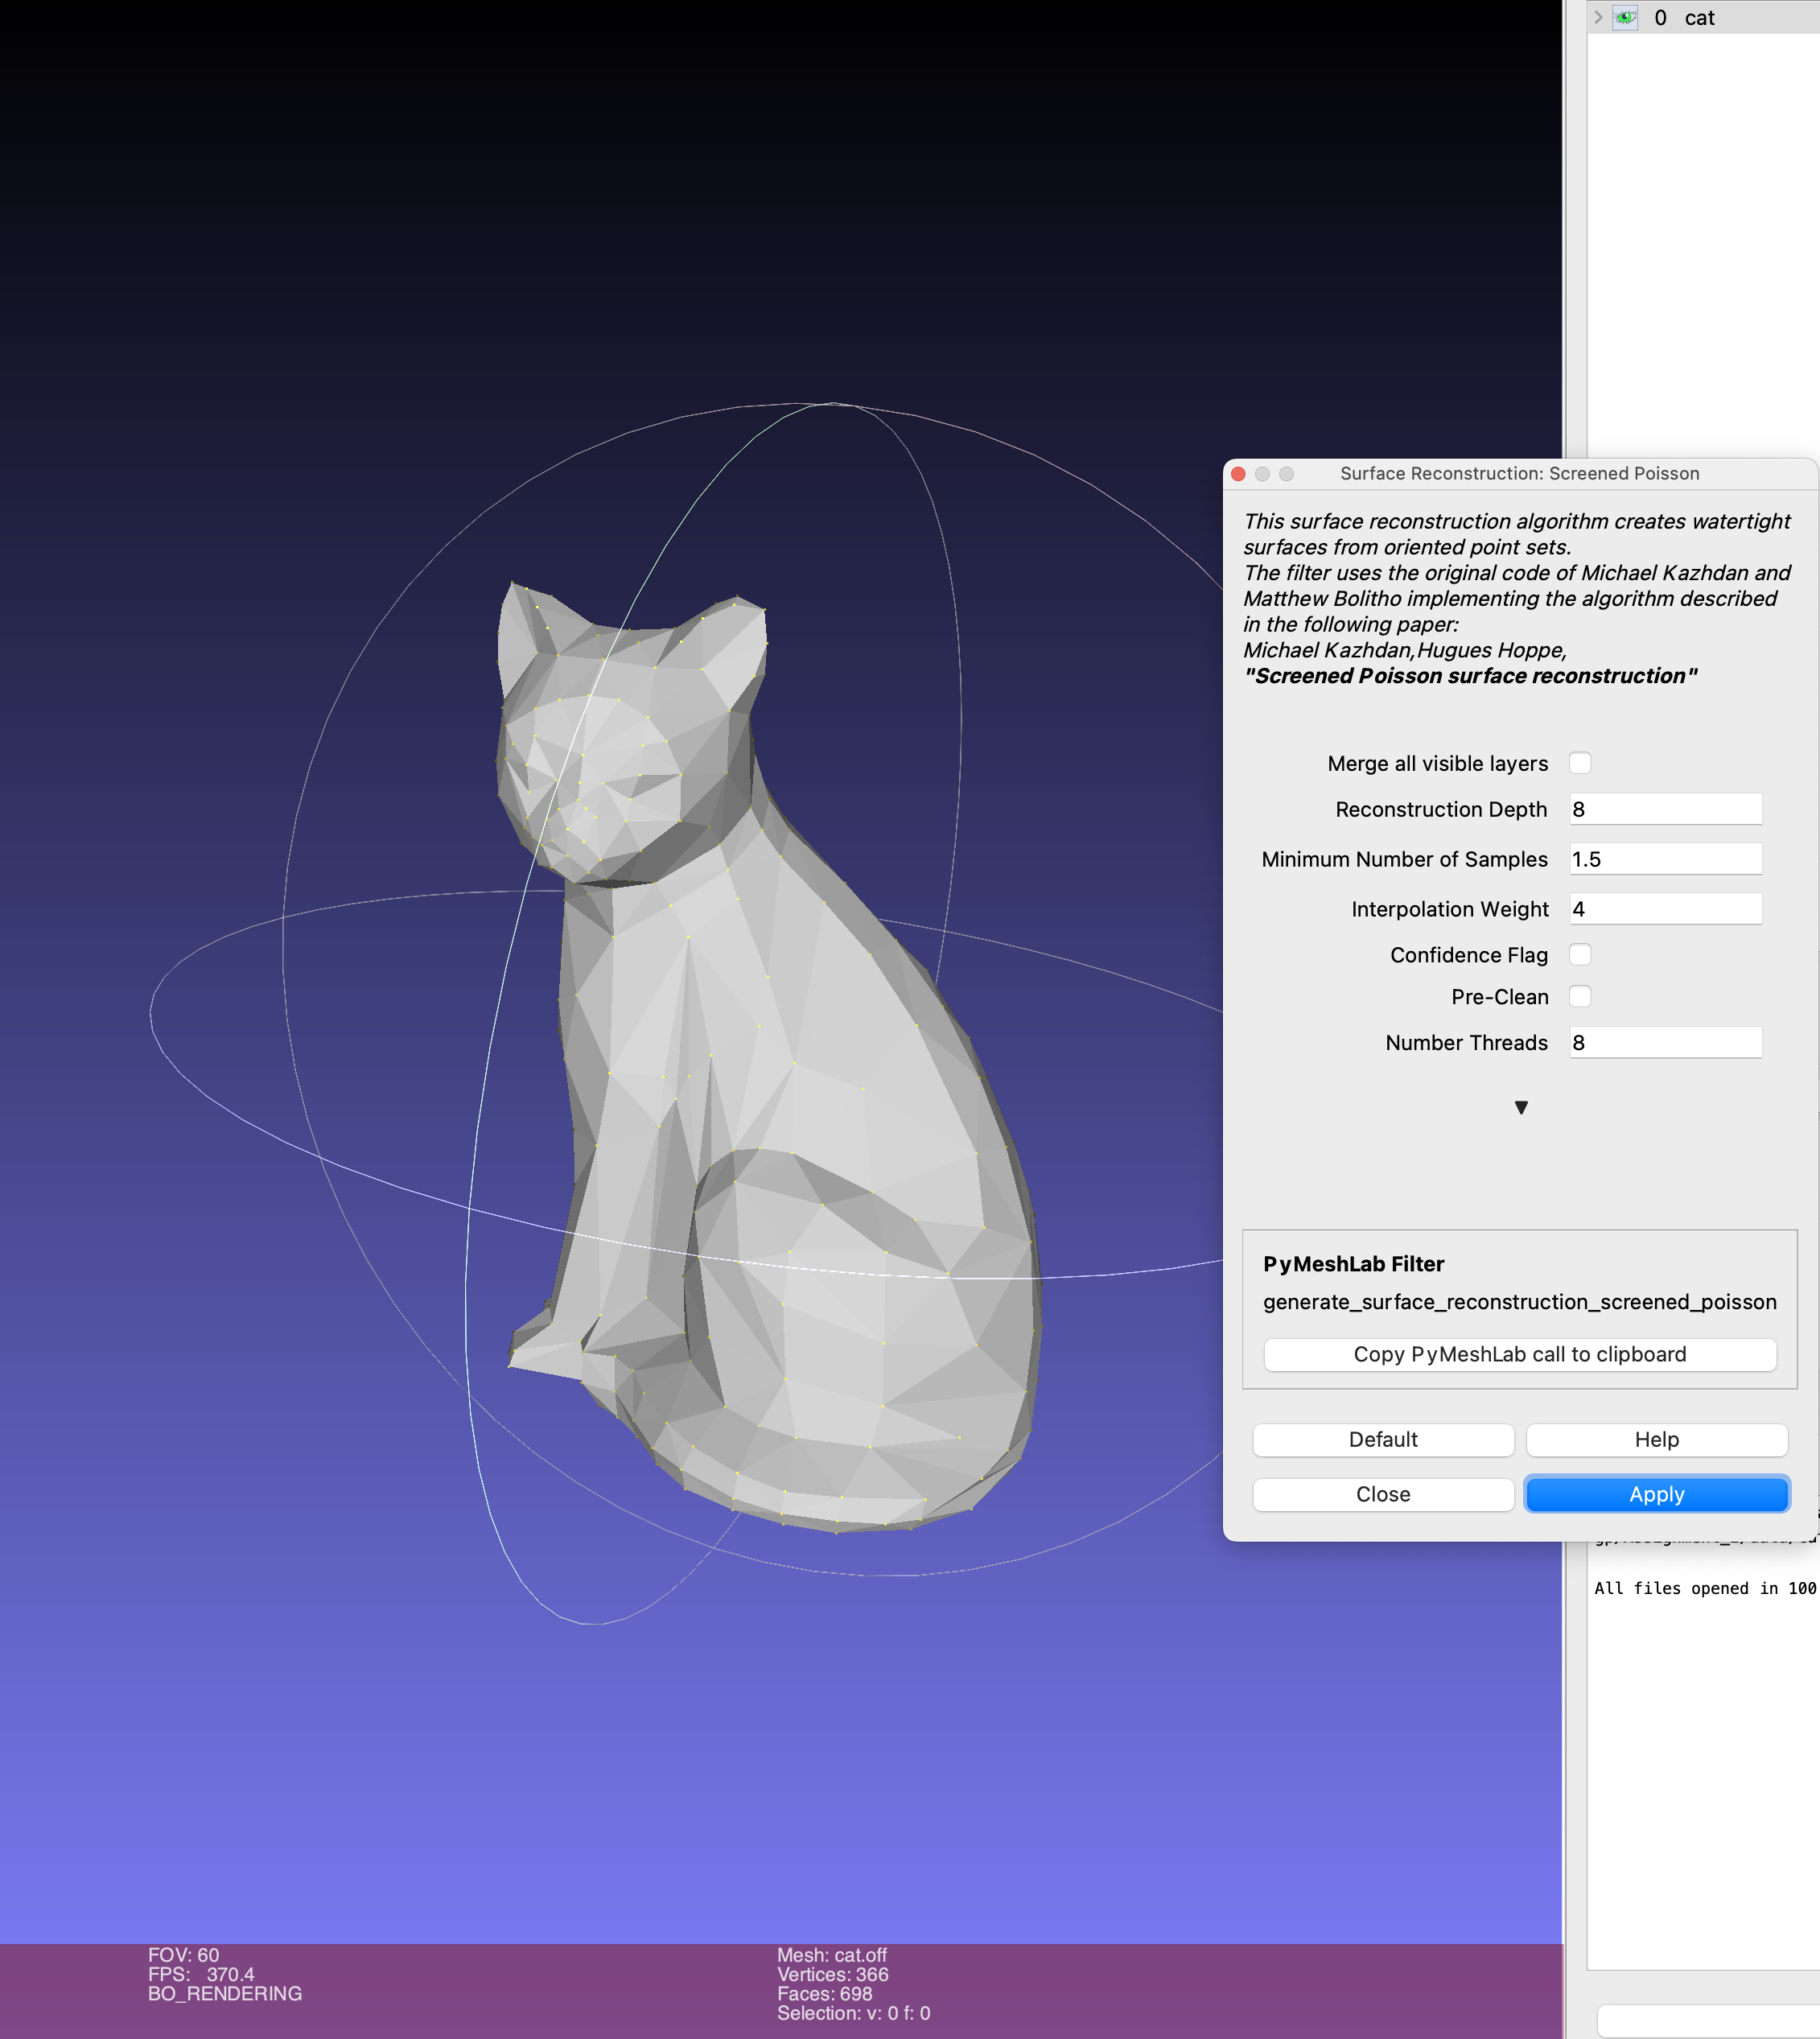
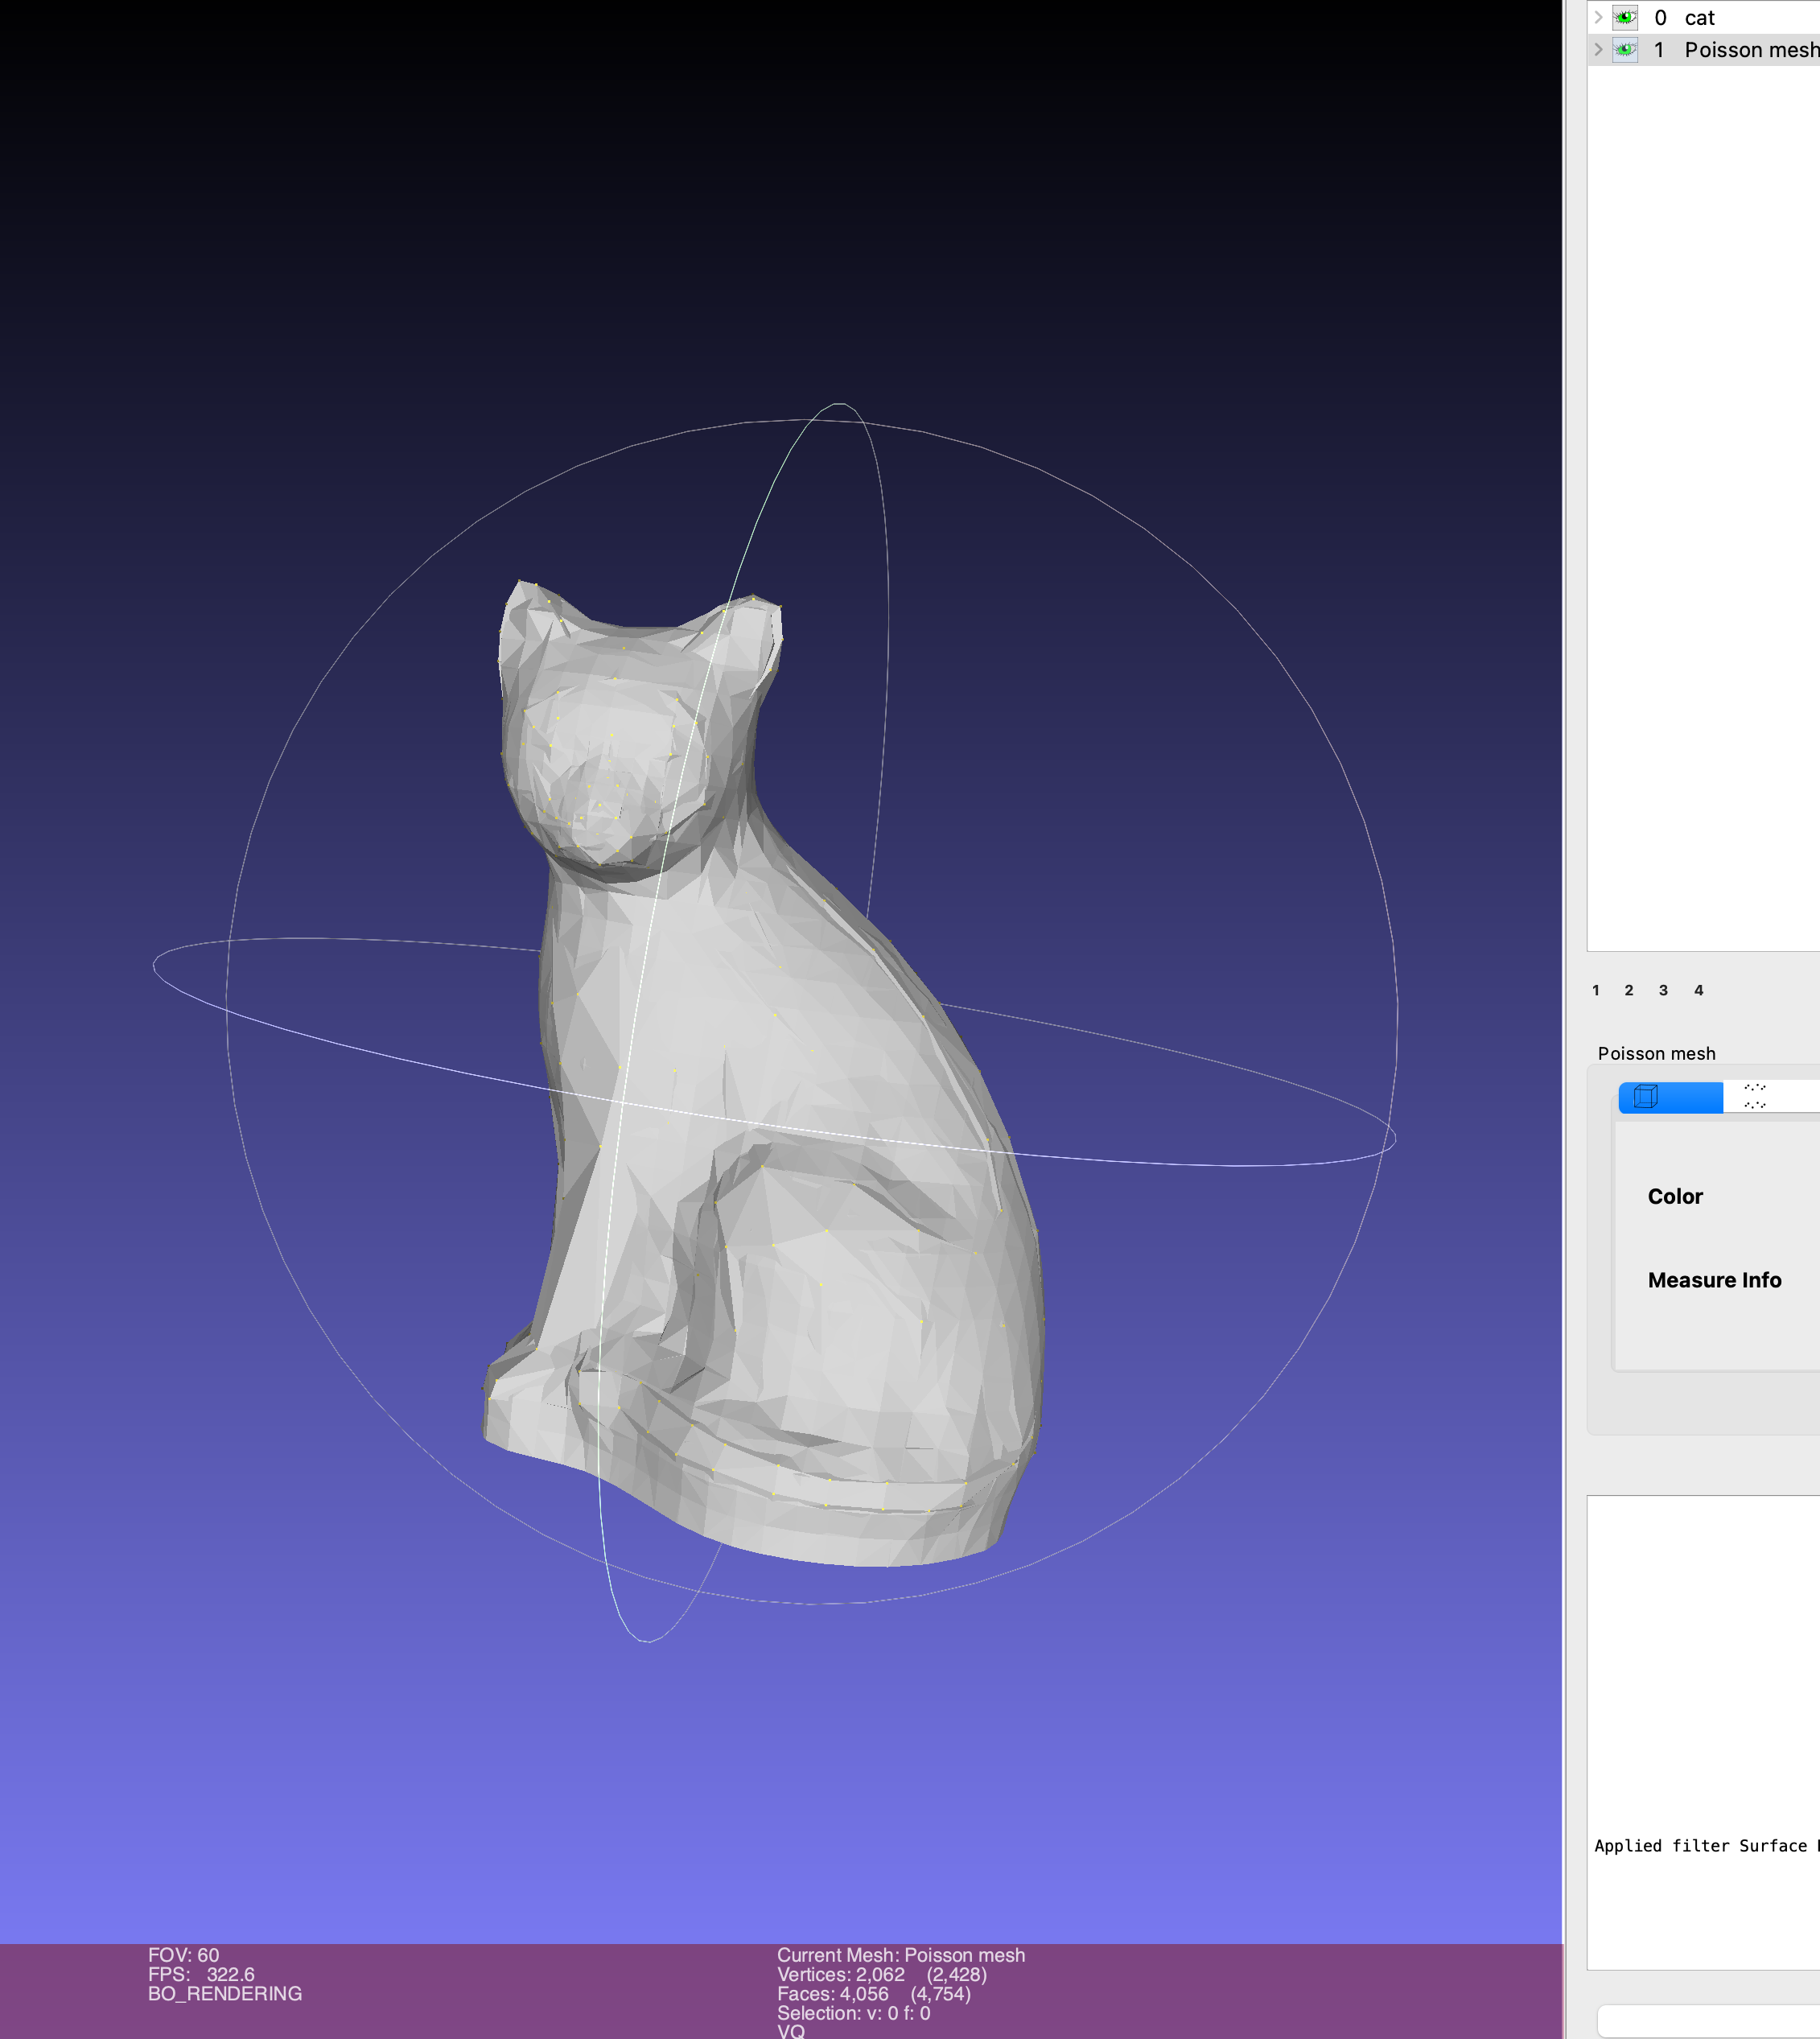


 The poisson recostruction first and foremost has much fewer artifacts than my recognstruction. This is probably because the global nature of the poisson reconstruction helps it better deal with noise. Also, the reconstructions are less rigid. If you focus on specifically the cat's mouth, my reconstruction is much more jagged/rigid compared to the more flat result from MeshLab. Additionally, with the poisson reconstruction, you can see details on the cat's ears (see below), which you cannot with my MLS reconstruction(at least as it's implemented here). Some of this may be due to the fact I have to increase how fine my grid is, but there must be other factors.
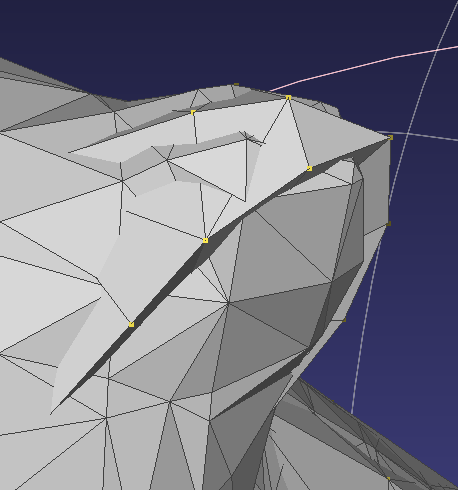

* *(2 points)* In [Interpolating and Approximating Implicit Surfaces from Polygon Soup](http://graphics.berkeley.edu/papers/Shen-IAI-2004-08/index.html) normals are used differently to define the implicit surface. Instead of generating new sample points offset in the positive and negative normal directions, the paper uses the normal to define a linear function for each point cloud point: the signed distance to the tangent plane at the point.
Then the values of these linear functions are interpolated by MLS. Implement Section 3.3 of the paper and append to your report a description of the method and how it compares to the original point-value-based approach.
Estimate a normal for results obtained with single dataset.